# we'll train a cnn to clssify images from cifar database

In [1]:
#since the images are large (32*32*3),we may use GPU
#test for cuda
import torch
import numpy as np
#check if CUDA is available
train_on_gpu=torch.cuda.is_available()
if not train_on_gpu:
    print("Cuda is not availlable!.Train on CPU")
else:
    print("Cuda availlable! Train on GPU")

Cuda is not availlable!.Train on CPU


# LOAD THE DATA

In [2]:
#we load train and test data
#split train data into train  data and validation sets
#then add dataloaders to each of these sets
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#number of subprocesses to use for loading
num_workers=0
#how many samples per batch
batch_size=20
#%of train dataset to use as validation set
valid_size=0.2

#convert the data into normalized torch.FloatTensor
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#now we choose the training and test datasets
train_data=datasets.CIFAR10("data",train=True,download=True,transform=transform)
test_data=datasets.CIFAR10("data",train=False,download=True,transform=transform)

#obtain the training indices that would be used for validation
num_train=len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)
split=int(np.floor(valid_size*num_train))
train_idx,valid_idx=indices[split:],indices[:split]

#define samplers for obtaining training and validaion batches
train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

#prepare dataloaders
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,
                                        num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,
                                        num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

#specify image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
                                        

Files already downloaded and verified
Files already downloaded and verified


# we visualize a batch of training data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

#defining an helper function to help us unormalize and visualize th batch size of the images
def imshow(img):
    img=img/2+0.5#unnormalizing the image
    plt.imshow(np.transpose(img,(1,2,0)))

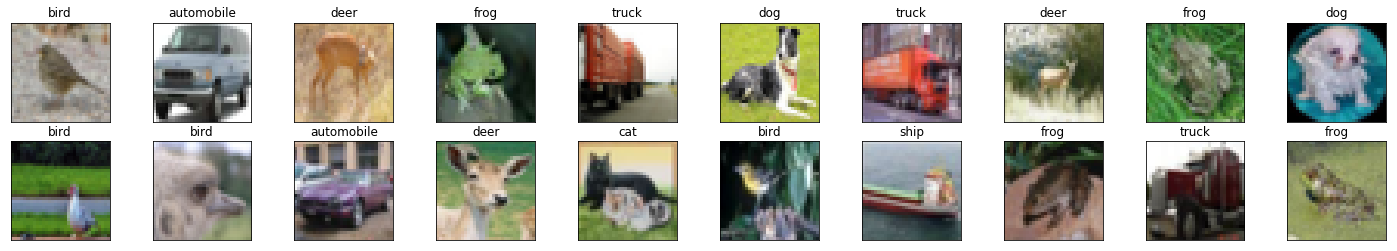

In [4]:
#visualizing one batch of the data
dataiter=iter(train_loader)
images,labels=dataiter.next()
images=images.numpy()#convert the images into a numpy array

#we want to plot our images of the batch alongside their labels
fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
    




# Viewing an image in more detail

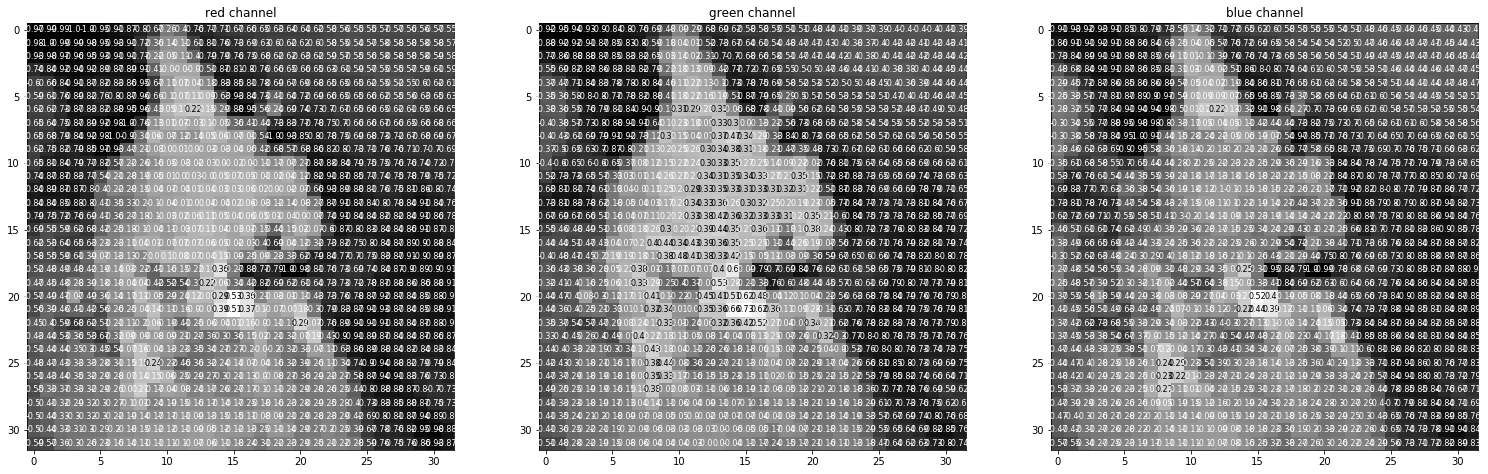

In [5]:
#we want to separete the rgb images into 3 ways
rgb_img=np.squeeze(images[3])
channels=["red channel","green channel","blue channel"]

fig=plt.figure(figsize=(26,36))
for idx in np.arange(rgb_img.shape[0]):
    ax=fig.add_subplot(1,3,idx+1)
    img=rgb_img[idx]
    ax.imshow(img,cmap="gray")
    ax.set_title(channels[idx])
    width,height=img.shape
    tresh=img.max()/2.5
    
    for x in range(width):
        for y in range(height):
            val=round(img[x][y],2) if img[x][y]!=0 else 0
            ax.annotate(str(val),xy=(y,x),
                       horizontalalignment='center',
                       verticalalignment='center',size=8,
                       color='white' if img[x][y]<tresh else 'black')


# we define the network architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F
#defining the class arcchitecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #here a convolutional layer sees 32*32*3 image tensor
        self.conv1=nn.Conv2d(3,16,3,padding=1)
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        #max pooling layer
        self.pool=nn.MaxPool2d(2,2)
        
        #linear layer
        self.fc1=nn.Linear(64*4*4,500)
        self.fc2=nn.Linear(500,10)
        
        #droupout layer (probablility=0.25)
        self.dropout=nn.Dropout(0.25)
        
    def forward(self,x):
        #adding a sequence of convolutional and maxpoolin layares
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        
        #flatten the image
        x=x.view(-1,64*4*4)
        #add a dropout layer
        x=self.dropout(x)
        #add 1st hidden layer with relu activation function
        x=F.relu(self.fc1(x))
        #add dropot layer
        x=self.dropout(x)
        #add 2nd hidden layer with relu activation layer
        x=self.fc2(x)
        
        return x
    
    
model= Net()
print(model)

#move tensor to gpu if CUDA is availlable
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


# specify the Loss function and Optimizer

In [7]:
import torch.optim as optim
#specify the loss function
criterion=nn.CrossEntropyLoss()

#specify the optimizer
optimizer=optim.SGD(model.parameters(),lr=0.01)

# Train The network

In [14]:
#we look on how thw training and validation loss decreases over time
#if the training and validation loss increases over time there is a posiibility of overfitting
#number of epochs to train the model
n_epochs=30
valid_min_loss=np.Inf#track the change in validation loss
for epoch in range(1,n_epochs+1):
    #track train and validation loss
    train_loss=0.0
    valid_loss=0.0
    
    #training our model##
    model.train()
    for data,target in train_loader:
        #move the tensors into gpu if cuda is availlable
        if train_on_gpu:
            data,target=data.cuda(),target.cuda()
        #clear the gradient for all optimized variables
        optimizer.zero_grad()
        #forward pass:compute the predicted outputs by passing inputs to the model
        output=model(data)
        #calculate the batch loss
        loss=criterion(output,target)
        #backward pass:computing the gradient of the loss with respect to the model parameters
        loss.backward()
        #perform a single optimization step(parameter update)
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        
        #validate the model#
    model.eval()
    for data,target in valid_loader:
        if train_on_gpu:
            data,target=data.cuda(),target.cuda()
            #forward pass
        output=model(data)
            #calculate the batch loss
        loss=criterion(output,target)
            #update thr average validatio loss
        valid_loss+=loss.item()*data.size(0)
            
            #calculating average losses
    train_loss=train_loss/len(train_loader.dataset)
    valid_loss=valid_loss/len(valid_loader.dataset)
    
    #printing the training and vlidation statistics
    print("Epoch {} \t Training loss:{:.6f}\t validation loss:{:.6f}".format(epoch,train_loss,valid_loss))
    
    #we save the model if the validation loss has decreased
    if valid_loss<=valid_min_loss:
        print("Validation loss decreased from {:.6f}---->{:.6f} now saving the model..".format(valid_min_loss,
                                                                                               valid_loss))
        torch.save(model.state_dict(),"model_cifar.pt")
        valid_min_loss=valid_loss
        
            
            

Epoch 1 	 Training loss:1.368381	 validation loss:0.301593
Validation loss decreased from inf---->0.301593 now saving the model..
Epoch 2 	 Training loss:1.184926	 validation loss:0.271276
Validation loss decreased from 0.301593---->0.271276 now saving the model..
Epoch 3 	 Training loss:1.089210	 validation loss:0.252814
Validation loss decreased from 0.271276---->0.252814 now saving the model..
Epoch 4 	 Training loss:1.019875	 validation loss:0.238776
Validation loss decreased from 0.252814---->0.238776 now saving the model..
Epoch 5 	 Training loss:0.953772	 validation loss:0.221664
Validation loss decreased from 0.238776---->0.221664 now saving the model..
Epoch 6 	 Training loss:0.892921	 validation loss:0.206425
Validation loss decreased from 0.221664---->0.206425 now saving the model..
Epoch 7 	 Training loss:0.843185	 validation loss:0.196208
Validation loss decreased from 0.206425---->0.196208 now saving the model..
Epoch 8 	 Training loss:0.798337	 validation loss:0.187950
V

In [15]:
#load the model with lowest validation loss
model.load_state_dict(torch.load("model_cifar.pt"))

# Test The Trained network

In [17]:
#track the test losses
test_loss=0.0
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))

model.eval()
for data,target in test_loader:
    #move the tensors into cpu if CUDA is availlable
    if train_on_gpu:
        data,target=data.cuda(),target.cuda()
    #forward pass:
    output=model(data)
    #calculate loss
    loss=criterion(output,target)
    #update the loss
    test_loss+=loss.item()*data.size(0)
    #convert the output probabilities to predicted class
    _,pred=torch.max(output,1)
    #compare the predictions to the true label
    correct_tensor=pred.eq(target.data.view_as(pred))
    correct=np.squeeze(correct_tensor.numpy())if not train_on_gpu else np.squeeze(corect_tensor.cpu().numpy())
    #calculate the test acuracy of each object class
    for i in range(batch_size):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
        
#average test loss
test_loss=test_loss/len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i]>0:
        print("Test_accuracy of %5s: %2d%%(%2d/%2d)"%(classes[i],100*class_correct[i]/class_total[i],
                                                     np.sum(class_correct[i]),np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.720373

Test_accuracy of airplane: 79%(798/1000)
Test_accuracy of automobile: 89%(892/1000)
Test_accuracy of  bird: 67%(672/1000)
Test_accuracy of   cat: 50%(506/1000)
Test_accuracy of  deer: 73%(732/1000)
Test_accuracy of   dog: 66%(666/1000)
Test_accuracy of  frog: 85%(856/1000)
Test_accuracy of horse: 75%(759/1000)
Test_accuracy of  ship: 88%(889/1000)
Test_accuracy of truck: 81%(810/1000)

Test Accuracy (Overall): 75% (7580/10000)


# Visuaalize a batch sample test results

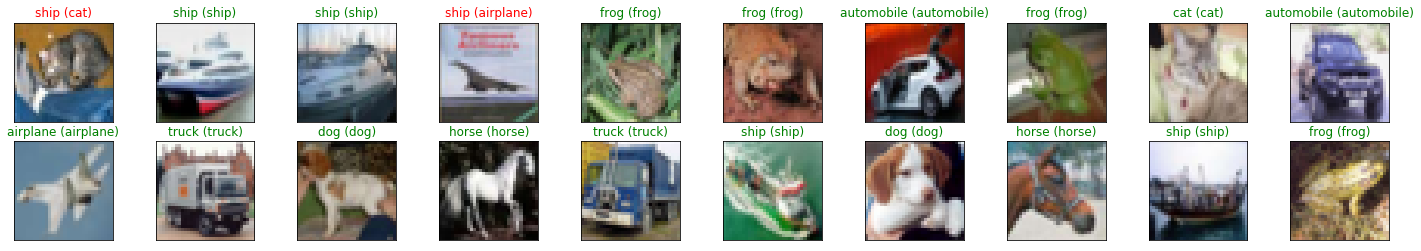

In [20]:
#obtain a batch of test images
dataiter=iter(test_loader)
images,labels=dataiter.next()
images.numpy()


#we move model inputs to gpu if cuda is availlable
if train_on_gpu:
    images=images.cuda()
    
#get sample outputs
output=model(images)
#convert outprut probabilities  to probabi;ity class
_,preds_tensor=torch.max(output,1)
preds=np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor().cpu().numpy())

#print the predicted images along with true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))



# CONCLUSION

In [ ]:
#does poor on animals esp cats,maybe because they vary in size and color
#we can try imporove the accuracy of our model by:
# 1.maybe increase the number of animal images 
#2. try to add another convolutional layer to detect finer patterns in these images
#experiment with a smaller learning rate so that the model takes small steps in the 
#right direction as it is training.